# When are the best times to stream on Twitch?

## 1 Searching for a better time to stream

With the onset of the coronavirus pandemic, many stayed home, hoping to evade COVID-19. Sudden lifestyle changes led to skyrocketing traffic for many streaming services. Many started watching streams, and many started streaming. These were the days when any new streamer would quickly gain attention. However, the quarantine buff has begun to wear off. So how can a rookie channel thrive in 2023?

Considering that budding streamers may already have charming personas, one can attempt to boost discoverability by streaming at strategic times. A blog post by Troy Nielsen on finding "The Best Time to Stream on Twitch in 2023" suggests one method. Utilizing the data provided by "Sullygnome.com" by David Boyd, Nielson takes into account the category and language, the days and hours with viewership numbers close to the average, and the days and hours with the lowest number of channels.

This project is an attempt to revisualize the data gathered by Boyd, filtered by features suggested by Nielsen, along with an additional feature to target the hours of most viewers to channels. In other words, hours with viewers close to the average but with a low number of active channels and a high viewer-to-channel ratio will be the optimal time for commencing streamers to start a stream. Other features may be more critical for established channels but differ from this project's focus.

Data science techniques, with the aid of Python libraries such as Requests, Pandas, NumPy, and Matplotlib, will be used to explore the data from Twitch during the year 2022. Note that a quick search indicated no similar work regarding exploring Twitch data for the best streaming time using data science techniques.

## 2 Looking for the data

The data used for this project, as cited in Nielson's blog post, come from the APIs used in "SullyGnome.com" by David Boyd. Multiple requests were made with different endpoints to gather data for both viewers and channels by the hour for a given year, category, and language. Because the original data is for the charts on the website, some modifications were necessary to extract parts of interest but include all required data. However, the format of the acquired data streamlined the mutations, and little tweaks and cleaning were enough to turn the JSON into DataFrames.

The terms for "SullyGnome.com" states that one is "welcome to use/share snippets of the data/tables/charts on the site" as long as one gives accreditation. Therefore, although one should credit Boyd for the collected data, the visualizations and the analyses made with them belong to this project's author and should be cited accordingly.

If many starting streamers decide to use the conclusions of this project to schedule their streams strategically, it may affect future data in ways that reshape the conclusions. However, the shift should not result in danger or harm.

Because the data is not of individuals, there is no potential for personally identifiable distinctions. Also, by taking averages as a basis for further exploration, potential biases have been considered.

Other websites, such as "twitchtracker.com" and "streamscharts.com," were also considered as data sources, but they lacked filtering by both category and language simultaneously. The websites above were, however, better than Boyd's for getting analytics related to individual channels.

## 3 Preparing the data



The data should be fetched and normalized for easy handling.

In [1]:
# To validate data
import re

# To make API requests
import requests

# To make data handling easier
import pandas as pd

# For efficiency
import numpy as np

# For visualizations
import matplotlib.pyplot as plt

In [2]:
year = 2022
categories = [
    {
        'code': 95075,
        'name': 'Software and Game Development'
    },
    {
        'code': 46369,
        'name': 'Just Chatting'
    },
    {
        'code': 46370,
        'name': 'Travel & Outdoors'
    },
    {
        'code': 37,
        'name': 'Music'
    },
    {
        'code': 46375,
        'name': 'Art'
    }
]
# language code: English = 217
language = 217

In [3]:
def get_data(year, category):
    """
    Get data for streams in English in the given category on Twitch for a given year for analysis
    
    Arguments:
        year: integer,
        category: {
            'code': integer
            'name': string
        }
        
    Returns:
        labels: datetimes of each data
        viewers: number of viewers for each datetime
        channels: number of channels for each datetime
    """

    labels = []
    viewers = []
    channels = []

    # Get data for each month of the year
    for month in range(12):
        # Get labels and viewers
        responseV = requests.get(
            'https://sullygnome.com/api/charts/linecharts/getconfig/GameViewers/7/0/' + str(category['code']) + '/' + category['name'] + '/%20/%20/' + str(year) + '/' + str(month + 1) + '/%20/' + str(language) + '/',
            headers={
                "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36"
            }
        ).json()
        
        labels.append(responseV['data']['labels'])
        viewers.append(responseV['data']['datasets'][0]['data'])

        # Get channels
        responseC = requests.get(
            'https://sullygnome.com/api/charts/linecharts/getconfig/GameChannels/7/0/' + str(category['code']) + '/' + category['name'] + '/%20/%20/' + str(year) + '/' + str(month + 1) + '/%20/0/',
            headers={
                "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36"
            }
        ).json()

        channels.append(responseC['data']['datasets'][0]['data'])

    # Flatten data
    labels = sum(labels, [])
    viewers = sum(viewers, [])
    channels = sum(channels, [])

    return labels, viewers, channels

help(get_data)

Help on function get_data in module __main__:

get_data(year, category)
    Get data for streams in English in the given category on Twitch for a given year for analysis
    
    Arguments:
        year: integer,
        category: {
            'code': integer
            'name': string
        }
        
    Returns:
        labels: datetimes of each data
        viewers: number of viewers for each datetime
        channels: number of channels for each datetime



In [4]:
def normalize_data(labels, viewers, channels):
    """
    Get a DataFrame given the labels, viewers, and channels to make data handling a breeze
    
    Arguments:
        labels: array
        viewers: array
        channels: array
        
    Returns:
        df: DataFrame of collected data
    """

    data = []
    faultyData = []
    regex = re.compile('\d+')

    for index, datetime in enumerate(labels):
        v = viewers[index]
        c = channels[index]

        # Get indices of faulty labels
        if not bool(regex.match(str(v))) or not bool(regex.match(str(c))):
            faultyData.append(index)
            continue

        # Append valid data
        data.append([v, c, v / c])

    # Get rid of faulty labels
    for i in faultyData:
        del labels[i]

    # Make a DataFrame with the data
    df = pd.DataFrame(data, index=labels, columns=['Viewers', 'Channels', 'Viewers to Channels'])

    return df

help(normalize_data)

Help on function normalize_data in module __main__:

normalize_data(labels, viewers, channels)
    Get a DataFrame given the labels, viewers, and channels to make data handling a breeze
    
    Arguments:
        labels: array
        viewers: array
        channels: array
        
    Returns:
        df: DataFrame of collected data



## 4 Making sense of the data

Filtered data, focusing on certain features, should be visualized for analysis.

In [5]:
def filter_data(df):
    """
    Get a filtered DataFrame for the analysis of the hours with at least the target number of viewers,
    less than the target number of active channels, and a viewers to channels ratio above the target
    
    Arguments:
        df: DataFrame
        
    Returns:
        filteredDF: filtered DataFrame
    """

    # Define targets for viewers, channels, and viewers to channels ratio
    targetMinViewers = df['Viewers'].mean() - df['Viewers'].std() * 0.8
    targetMaxViewers = df['Viewers'].mean() + df['Viewers'].std() * 0.8
    targetChannels = df['Channels'].mean() - df['Channels'].std() * 1.2
    targetViewersToChannels = df['Viewers to Channels'].mean() + df['Viewers to Channels'].std()

    # Filter DataFrame object with targets defined above
    filteredDF = df[
        (df['Viewers'] > targetMinViewers)
        & (df['Viewers'] < targetMaxViewers)
        & (df['Channels'] < targetChannels)
        & (df['Viewers to Channels'] > targetViewersToChannels)
    ]

    # Display an overview of the filtered DataFrame object
    display(filteredDF.describe())

    return filteredDF

help(filter_data)

Help on function filter_data in module __main__:

filter_data(df)
    Get a filtered DataFrame for the analysis of the hours with at least the target number of viewers,
    less than the target number of active channels, and a viewers to channels ratio above the target
    
    Arguments:
        df: DataFrame
        
    Returns:
        filteredDF: filtered DataFrame



In [6]:
def visualize_data(category, df):
    """
    Plot a scatter plot for the given category and DataFrame to visualize the data
    
    Arguments:
        category: string
        df: DataFrame
        
    Returns:
        plt: scatter plot of filtered DataFrame
    """

    # Change the datetime in labels to hours
    hours = [int(index[11:13]) for index in df.index]
    df.rename(index = {index: hour for index, hour in enumerate(hours)})

    # Set colors to reflect Viewers
    colors = df['Viewers']

    # Get figure and axes
    fig, ax = plt.subplots()

    # Set size of figure
    fig.set_size_inches(16, 8)

    # Set axes so that
    # the x-axis is "Hours of the day (UTC)"
    # and the y-axis is "Active channels"
    ax.xaxis.set_ticks(np.array(hours))
    ax.set_xlabel('Hours of the day (UTC)')
    ax.set_ylabel('Active channels')

    # Create a scatter plot with the title,
    # "When are the best times to stream {category} on Twitch?",
    # where the size and color of each point is dependent on the number of viewers
    ax.set_title('When are the best times to stream ' + category + ' on Twitch?')
    ax.scatter(hours, df['Channels'], s=df['Viewers'] ** 0.75, c=colors, alpha=0.5)

help(visualize_data)

Help on function visualize_data in module __main__:

visualize_data(category, df)
    Plot a scatter plot for the given category and DataFrame to visualize the data
    
    Arguments:
        category: string
        df: DataFrame
        
    Returns:
        plt: scatter plot of filtered DataFrame



In [7]:
def analyze_data(category):
    """
    Get an overview of the data for analysis
    
    Arguments:
        category: string
    """

    labels, viewers, channels = get_data(year, next(c for c in categories if c['name'] == category))
    df = normalize_data(labels, viewers, channels)
    filteredDF = filter_data(df)
    visualize_data(category, filteredDF)

help(analyze_data)

Help on function analyze_data in module __main__:

analyze_data(category)
    Get an overview of the data for analysis
    
    Arguments:
        category: string



## 5 Analyzing the data

Looking at the visualizations below, the best times for new streamers would be hours with multiple points plotted, preferably yellower and bigger, while also being lower on the scale of the active channel.

,Viewers,Channels,Viewers to Channels
count,174.000000,174.000000,174.000000
mean,152176.614943,2498.488506,60.949938
std,22628.059084,224.125139,7.691575
min,98671.000000,1844.000000,51.150385
25%,136068.750000,2360.250000,54.603554
50%,148332.500000,2512.000000,59.098437
75%,166936.250000,2682.500000,66.001398
max,202807.000000,2873.000000,83.955508


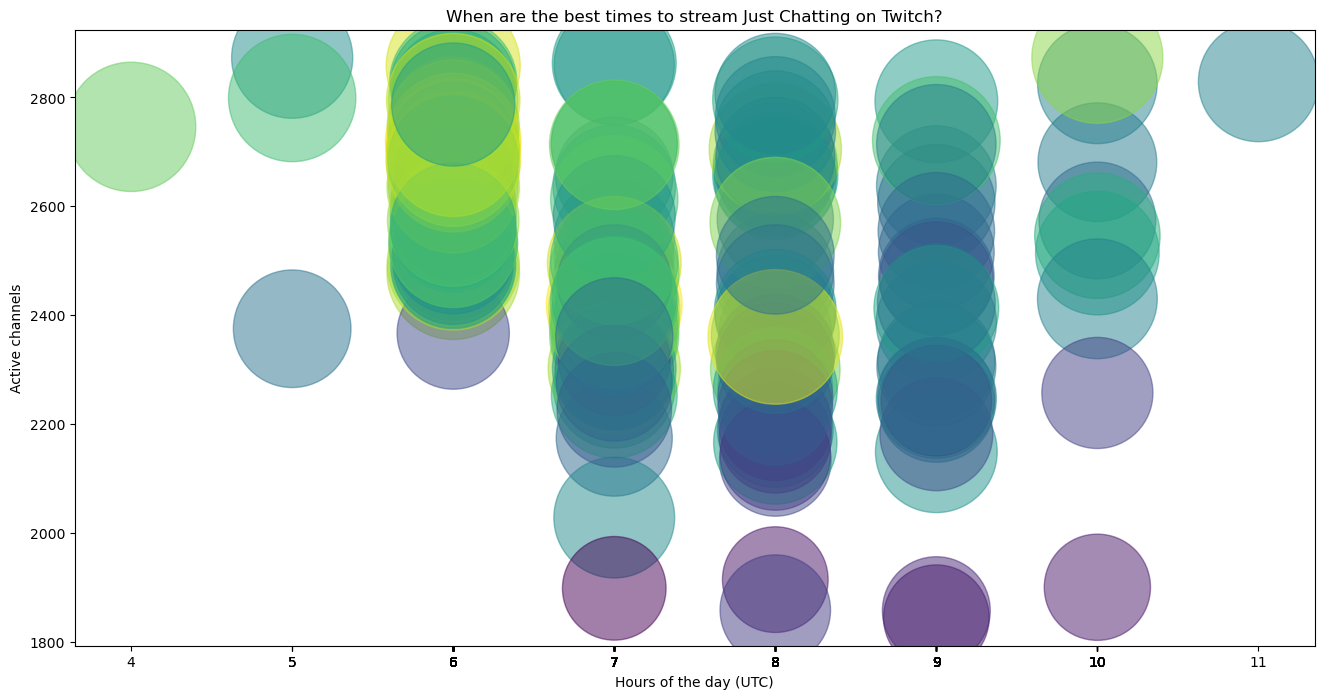

In [8]:
analyze_data('Just Chatting')

,Viewers,Channels,Viewers to Channels
count,47.000000,47.000000,47.000000
mean,22058.659574,708.787234,31.121923
std,2755.404778,56.356758,2.933115
min,16745.000000,538.000000,28.155050
25%,20497.000000,699.500000,28.857344
50%,21376.000000,726.000000,29.886981
75%,23702.000000,742.500000,32.692003
max,28583.000000,778.000000,39.023416


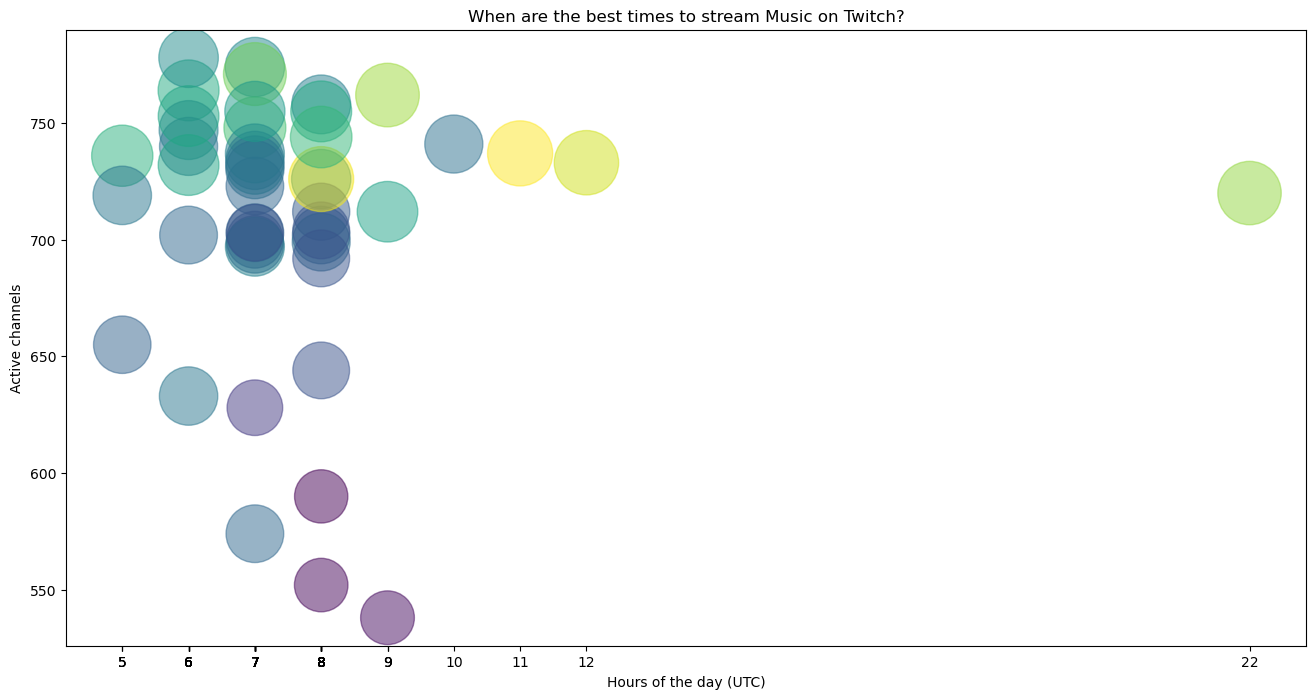

In [9]:
analyze_data('Music')

,Viewers,Channels,Viewers to Channels
count,225.000000,225.000000,225.000000
mean,7793.204444,441.146667,17.721253
std,1061.723646,37.163980,2.424031
min,5632.000000,324.000000,15.012685
25%,6985.000000,421.000000,15.786600
50%,7686.000000,448.000000,17.065359
75%,8613.000000,474.000000,19.188679
max,10031.000000,490.000000,26.163743


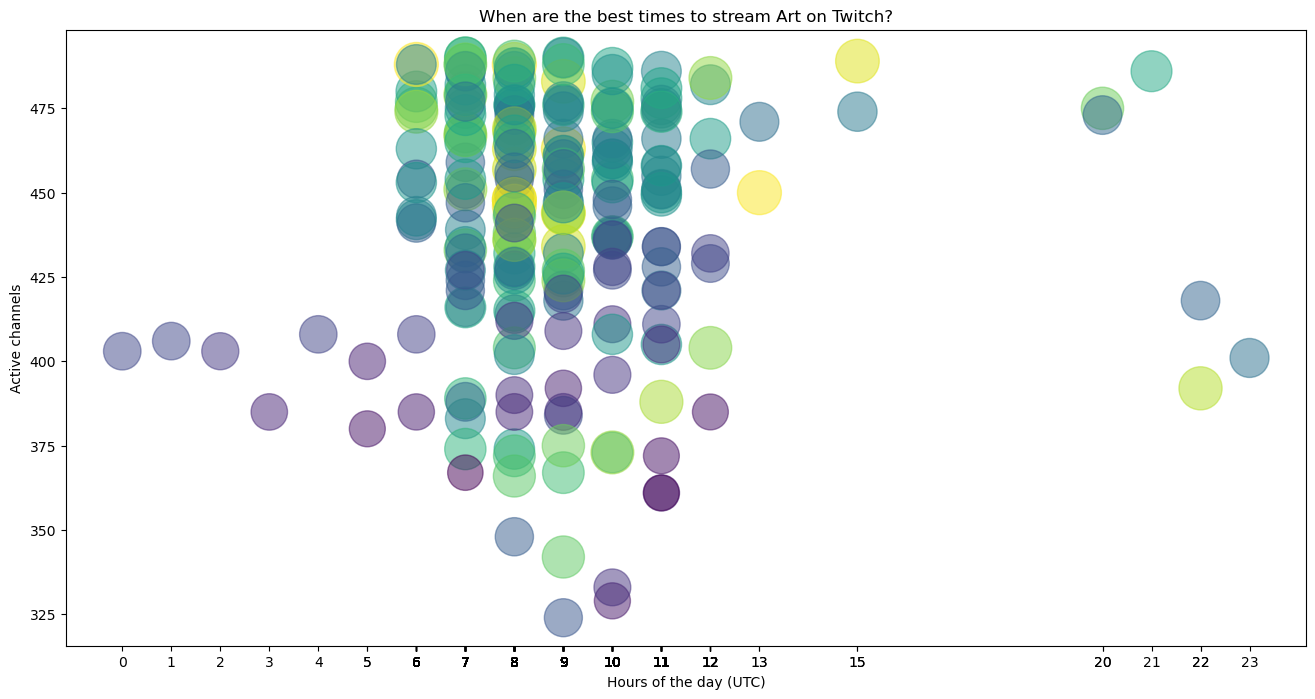

In [10]:
analyze_data('Art')

,Viewers,Channels,Viewers to Channels
count,82.000000,82.000000,82.000000
mean,1403.804878,75.097561,18.915022
std,114.351466,7.494211,3.001902
min,1017.000000,29.000000,16.538462
25%,1332.250000,72.000000,17.433299
50%,1420.000000,76.000000,18.335110
75%,1493.750000,79.750000,19.425906
max,1585.000000,84.000000,42.034483


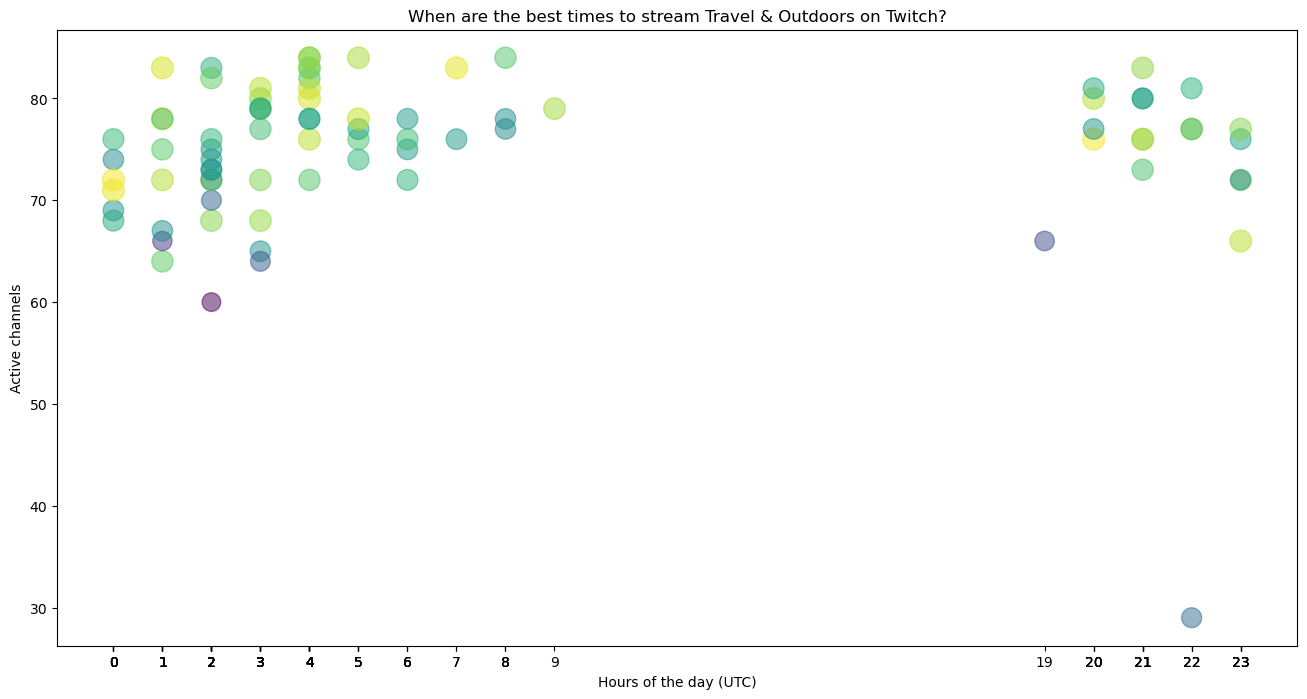

In [11]:
analyze_data('Travel & Outdoors')

,Viewers,Channels,Viewers to Channels
count,28.000000,28.000000,28.000000
mean,1226.071429,56.285714,21.861514
std,175.345570,5.536794,2.933163
min,913.000000,44.000000,18.090909
25%,1129.250000,53.750000,20.345523
50%,1192.000000,57.000000,21.145175
75%,1314.500000,60.250000,23.572917
max,1700.000000,64.000000,29.310345


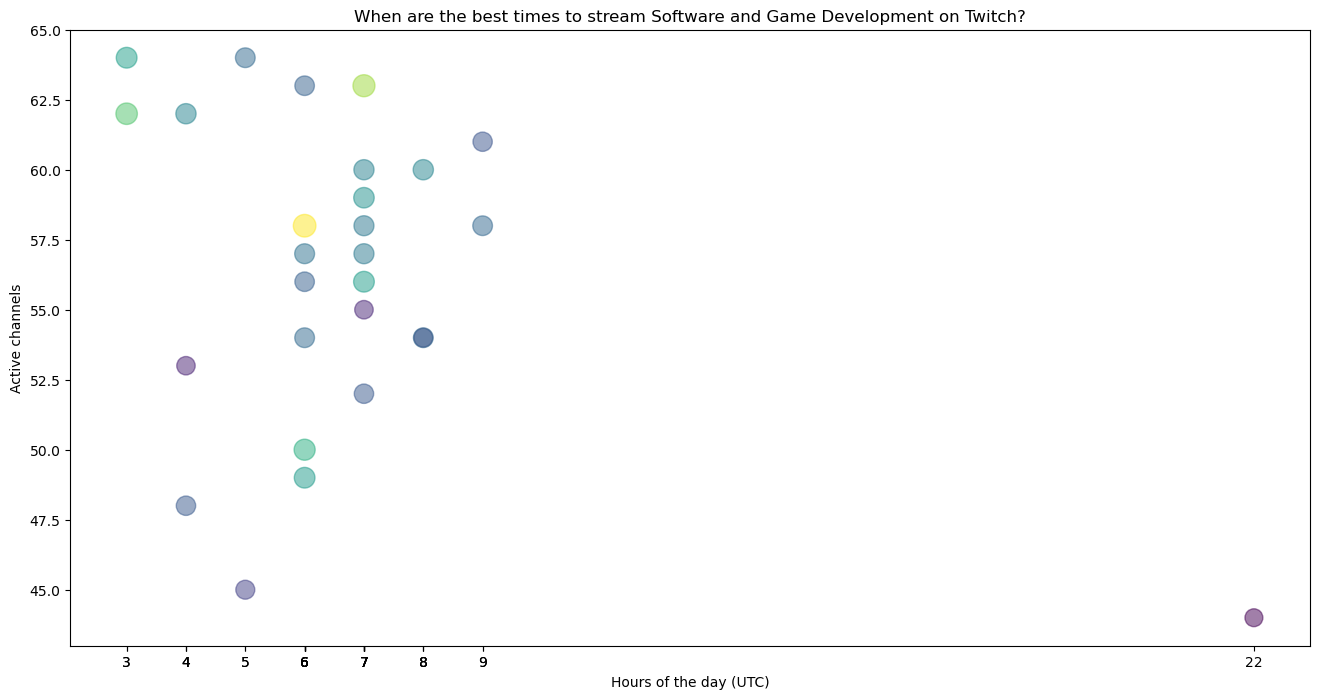

In [12]:
analyze_data('Software and Game Development')

## 6 Coming to a conclusion

The best times in UTC to stream in English on Twitch by category for new streamers are:
- 7-10 for "Just Chatting"
- 7-9 for "Music"
- 8-12 for "Art"
- 1-4 for "Travel & Outdoors"
- 6-8 for "Software and Game Development"

Except for "Travel & Outdoors," the above times are from late night to dawn in the US and from early morning to noon in the UK, suggesting that targeting English-speaking Europeans in their mornings may prove effective.

Further analysis regarding the days of the week would be valuable, considering that most people are busy during the weekdays and freer on weekends.

## 6 Giving credits

### Data

- David Boyd - SullyGnome.com

### Methodology

- Nielsen, T. (2022, December 9). The best time to stream on Twitch in 2023. Hootsuite. Retrieved January 10, 2023, from https://blog.hootsuite.com/best-time-to-stream-on-twitch/